# 1. Libraries

In [1]:
import os
import pandas as pd
import geopandas as gpd
from functools import reduce
import matplotlib.pyplot as plt
import contextily as ctx
import adjustText as aT
import folium
pd.set_option('display.max_columns', None)

In [2]:
#set working directory
os.chdir('C:/Users/amjar/Documents/Grad School/Capstone/Data/Cleaned')

# 2. Load & Organize Cleaned Data

## 2.1 Demographic/Administrative Data

In [3]:
race = gpd.read_file('race.geojson')
income = gpd.read_file('income.geojson')
tenure = gpd.read_file('tenure.geojson')
vehicles = pd.read_csv('vehicles.csv')
counties = gpd.read_file('counties.geojson')
cities = gpd.read_file('cities.geojson')

In [4]:
census = [race, income, tenure]
demog = reduce(lambda  left,right: pd.merge(left,right,on=['geoid'],
                                            how='outer', suffixes=('', '_y')), census)
demog.drop(demog.filter(regex='_y$'),axis=1, inplace=True)
# assign tract-level HH vehicle ownership to block groups
demog['tract'] = demog['geoid'].str[:-1]
demog['tract'] = demog['tract'].str[7:]
demog = demog.astype({'tract': 'int64'})
demog['geoid'] = demog['geoid'].str[7:]
demog = demog.merge(vehicles, on='tract')
demog.drop(demog.filter(regex='^Unnamed:'),axis=1, inplace=True)

# create county column
demog['COUNTY'] = demog['name'].str[15:]
demog['COUNTY'] = demog['COUNTY'].str.rstrip(', TX')

In [5]:
demog = demog[demog.COUNTY != 'Erath']
demog = demog[demog.COUNTY != 'Navarro']
demog = demog[demog.COUNTY != 'Palo Pinto']
demog = demog[demog.COUNTY != 'Somervell']

In [6]:
# calculate decile index values
demog = demog.dropna(subset=['Median Household Income'])
demog['income_idx'] = pd.qcut(demog['Median Household Income'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
demog['race_idx'] = pd.qcut(demog['Percent Not Latinx White'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
demog['renter_idx'] = pd.qcut(demog['Percent Renter'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
demog['vehicle_idx'] = pd.qcut(demog['Percent 0 Vehicles'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
demog = demog.astype({'income_idx': 'int', 'race_idx': 'int', 'renter_idx': 'int', 'vehicle_idx': 'int'})
demog['EFC_score'] = demog['income_idx'] + demog['race_idx'] + demog['renter_idx'] + demog['vehicle_idx']
demog['EFC_score'].describe()

count    4050.000000
mean       22.002716
std         6.191258
min         4.000000
25%        17.000000
50%        22.000000
75%        27.000000
max        40.000000
Name: EFC_score, dtype: float64

## 2.2 CRIS Collison/Crash Data

In [7]:
CRIS = gpd.read_file('CRIS_trim.geojson')
CRIS_fatal = CRIS.loc[CRIS['Crash Death Count'] > 0]

## 2.3 NCTCOG Mobility 2045 Travel Demand Model

In [8]:
YR18 = gpd.read_file('YR18.geojson')
YR45 = gpd.read_file('YR45.geojson')
YR18 = YR18.add_suffix('_18') 
YR45 = YR45.add_suffix('_45')

In [9]:
Mobility2045 = pd.merge(YR18, YR45, left_on='Shape_STLe_18', right_on='Shape_STLe_45')
Mobility2045.drop(['geometry_18'], axis=1, inplace=True)
Mobility2045.rename(columns={'geometry_45': 'geometry'}, inplace=True)
Mobility2045 = gpd.GeoDataFrame(Mobility2045, geometry='geometry')
# 35233 rows

### 2.3.1 Estimate Street Widths based on Functional Classification

In [10]:
# following https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
def generate_streetwidth (row):
    if row['FUNCL_18'] == 1 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*12
    if row['FUNCL_18'] == 2 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*11.5
    if row['FUNCL_18'] == 3 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*11.5
    if row['FUNCL_18'] == 4 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*11
    if row['FUNCL_18'] == 5 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*11.5
    if row['FUNCL_18'] == 6 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*12
    if row['FUNCL_18'] == 7 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*11.5
    if row['FUNCL_18'] == 8 :
        return (row['PKLNA_18'] + row['PKLNB_18'])*12
    
Mobility2045['total_street_width'] = Mobility2045.apply (lambda row: generate_streetwidth(row), axis=1)

## 2.4 Set Projection

In [11]:
datasets = [demog, cities, counties, Mobility2045, CRIS, CRIS_fatal]
for geodata in datasets:
    geodata.to_crs(3857, inplace=True)

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## 2.5 Street Network Length Calculations

In [12]:
Mobility2045['segment_length'] = Mobility2045.length
Mobility2045['segment_length_miles'] = Mobility2045['segment_length']*0.00062137
Mobility2045['lane_miles'] = (Mobility2045['PKLNA_18'] + Mobility2045['PKLNB_18']) * Mobility2045['segment_length_miles']

# 3. Match Demographic & Street Network Data to City/County Boundaries

## 3.1 Assign Block Groups to Cities/Counties

In [13]:
# adapted from https://gis.stackexchange.com/questions/273495/geopandas-how-to-spatially-join-based-on-maximally-overlapping-feature
def max_area_attr_join(gdf1, gdf2, id_col, attribute_col):
    #spatial overlay
    s = gpd.overlay(gdf1, gdf2, how = 'intersection') 
    s['area_ov'] = s.geometry.area
    
    gb = s.groupby(id_col)[['area_ov']].max()
    
    #add the column 'area_ov' to the original gdf.
    gdf1 = gdf1.merge(gb, left_on = id_col, right_index = True) 
    
    #drop extraneous columns from the joined gdf
    s = s[['area_ov', attribute_col]]
    
    #merge the attribute column to the original gdf.
    gdf1 = gdf1.merge(s, on = 'area_ov')

    return gdf1.drop(columns = ['area_ov'])

In [14]:
demog_city1 = max_area_attr_join(demog, cities, 'geoid', 'CITY')
# 4087 rows has lost the 50 block groups not w/no city overlap
# re-add the 50 block groups w/no city and fill NaA
# from https://stackoverflow.com/questions/65774788/add-rows-from-one-dataframe-to-another-based-on-missing-values-in-a-given-column
demog_cities = pd.concat([demog_city1, demog[~demog.geoid.isin(demog_city1.geoid)]])
demog_cities['CITY'] =  demog_cities['CITY'].fillna(demog_cities['COUNTY'] + ' (County)')

## 3.2 Assign Streets to Cities/Counties

In [15]:
# add 1 ft buffer to street linestrings to create polygons to allow for overlap operations
Mobility2045['buffer'] = Mobility2045['geometry'].buffer(0.3048)
Mobility2045.set_geometry('buffer', inplace=True)

In [16]:
street_counties = max_area_attr_join(Mobility2045, counties, 'Shape_STLe_45', 'COUNTY')
# 34932  rows has lost the 301 street segments not w/no county overlap
# re-add the street segments block groups w/no county 
# from https://stackoverflow.com/questions/65774788/add-rows-from-one-dataframe-to-another-based-on-missing-values-in-a-given-column
street_counties = pd.concat([street_counties, Mobility2045[~Mobility2045.Shape_STLe_45.isin(street_counties.Shape_STLe_45)]])

In [17]:
street_cities = max_area_attr_join(street_counties, cities, 'Shape_STLe_45', 'CITY')
# 30194 rows has lost the 5039 street segments not w/no city overlap
# re-add the street segments block groups w/no city 
# from https://stackoverflow.com/questions/65774788/add-rows-from-one-dataframe-to-another-based-on-missing-values-in-a-given-column
street_cities = pd.concat([street_cities, Mobility2045[~Mobility2045.Shape_STLe_45.isin(street_cities.Shape_STLe_45)]])

# 4. Collision/Crash Analysis

## 4.1 Match Crashes to Nearest Street (All Collisions)

In [18]:
# WARNING: street_cities's geometry is still set as the buffer column, not the original geometry column of linestrings
street_cities.set_geometry('buffer', inplace=True)
street_crash = gpd.sjoin_nearest(CRIS, street_cities, max_distance=50, distance_col='distances')
# 1138820 rows --> drop crashes more than 50 meters from nearest street
street_crash = street_crash[street_crash['distances'] <= 50]
# down to 892400 rows

In [19]:
crash_by_street = street_crash.groupby(['Shape_STLe_45']).count()
crash_by_street = crash_by_street['Crash ID']
#crash_by_street.drop(columns=['geometry_left', 'geometry_right', 'index_right', 'distances'], inplace=True)

In [20]:
Mobility2045_CRIS = pd.merge(street_cities, crash_by_street, how='left', on='Shape_STLe_45')
Mobility2045_CRIS['Crash ID'] =  Mobility2045_CRIS['Crash ID'].fillna(0)
Mobility2045_CRIS['Crash ID'].sum()

892400.0

## 4.2 Match Crashes to Nearest Street (Fatal Subset)

In [21]:
fatal_crash = gpd.sjoin_nearest(CRIS_fatal, street_cities, max_distance=50, distance_col='distances')
fatal_crash = fatal_crash[fatal_crash['distances'] <= 50]
fatal_by_street = fatal_crash.groupby(['Shape_STLe_45']).count()
fatal_by_street = fatal_by_street['Crash ID']
Mobility2045_CRIS = pd.merge(Mobility2045_CRIS, fatal_by_street, how='left', on='Shape_STLe_45')

In [22]:
Mobility2045_CRIS.rename(columns={'Crash ID_x': 'Crashes', 'Crash ID_y': 'Fatal_Crashes'}, inplace=True)
Mobility2045_CRIS['Crashes'] =  Mobility2045_CRIS['Crashes'].fillna(0)
Mobility2045_CRIS['Fatal_Crashes'] =  Mobility2045_CRIS['Fatal_Crashes'].fillna(0)
Mobility2045_CRIS['crash_per_mile'] = Mobility2045_CRIS['Crashes'] / Mobility2045_CRIS['segment_length_miles']
Mobility2045_CRIS['fatal_crash_per_mile'] = Mobility2045_CRIS['Fatal_Crashes'] / Mobility2045_CRIS['segment_length_miles']
Mobility2045_CRIS['crash_per_mile_vol'] = Mobility2045_CRIS['Crashes'] / Mobility2045_CRIS['segment_length_miles'] / (Mobility2045_CRIS['DAYVOL_AB_18'] + Mobility2045_CRIS['DAYVOL_BA_18'])
Mobility2045_CRIS['fatal_crash_per_mile_vol'] = Mobility2045_CRIS['Fatal_Crashes'] / Mobility2045_CRIS['segment_length_miles'] / (Mobility2045_CRIS['DAYVOL_AB_18'] + Mobility2045_CRIS['DAYVOL_BA_18'])
Mobility2045_CRIS['crash_idx'] = pd.qcut(Mobility2045_CRIS['crash_per_mile'].rank(method='first'), 10, labels=['1','2','3','4','5', '6', '7', '8', '9', '10'])
Mobility2045_CRIS['fatal_crash_idx'] = pd.qcut(Mobility2045_CRIS['fatal_crash_per_mile'].rank(method='first'), 10, labels=['1','2','3','4','5', '6', '7', '8', '9', '10'])
Mobility2045_CRIS.set_geometry('geometry', inplace=True)

In [23]:
Mobility2045_CRIS.sort_values(by=['fatal_crash_per_mile_vol'], ascending=False)

OBJECTID_18   ID_18 FAC_DIR_18              STREET_18  TRDIR_18  \
31812        21507  110711       None                 CR915B         2   
8874         14385  111189       None              HAINES RD         2   
31947        22025  112550       None           BOB WHITE RD         2   
32329        22821  110891       None                 CR1102         2   
32841        23663  110463       None  OLD MINERAL WELLS HWY         2   
...            ...     ...        ...                    ...       ...   
33823        31759   93863       None                 FM1181         2   
34035        32245   91038       None                   FM67         2   
34268        32749   89313       None           BANKHEAD HWY         2   
34487        33169   89682       None                 FM1181         2   
34947        38221   90550       None                  SH101         2   

       FUNCL_18  DIVID_18  CNTRLA_18  CNTRLB_18  USERLENGTH_18  PKLNA_18  \
31812         4         2          7          7             58         1   
8874          4         2          7          7            223         1   
31947         4         2          7          1             43         1   
32329         4         2          7          1             72         1   
32841         4         2          7          7              2         1   
...         ...       ...        ...        ...            ...       ...   
33823         3         2          1          1            187         1   
34035         3         2          1          7            696         1   
34268         3         2          1          7             40         1   
34487         3         2          1          1            262         1   
34947         2         2          1          1              3         1   

       OPLNA_18  SPLTA_18  PKLNB_18  OPLNB_18  SPLTB_18  THRULANES_18  \
31812         1        40         1         1        40             2   
8874          1        35         1         1        35             2   
31947         1        40         1         1        40             2   
32329         1        40         1         1        40             2   
32841         1        40         1         1        40             2   
...         ...       ...       ...       ...       ...           ...   
33823         1        55         1         1        55             2   
34035         1        50         1         1        50             2   
34268         1        40         1         1        40             2   
34487         1        55         1         1        55             2   
34947         1        65         1         1        65             2   

       TOLLROAD_18  TOLLMILE_18  TOLLA_18  TOLLB_18  TOLLA_AM_18  TOLLA_PM_18  \
31812            0          0.0         0         0            0            0   
8874             0          0.0         0         0            0            0   
31947            0          0.0         0         0            0            0   
32329            0          0.0         0         0            0            0   
32841            0          0.0         0         0            0            0   
...            ...          ...       ...       ...          ...          ...   
33823            0          0.0         0         0            0            0   
34035            0          0.0         0         0            0            0   
34268            0          0.0         0         0            0            0   
34487            0          0.0         0         0            0            0   
34947            0          0.0         0         0            0            0   

       TOLLA_OP_18  TOLLB_AM_18  TOLLB_PM_18  TOLLB_OP_18  TOLLMILE_A_18  \
31812            0            0            0            0            0.0   
8874             0            0            0            0            0.0   
31947            0            0            0            0            0.0   
32329            0            0            0       

In [24]:
danger = Mobility2045_CRIS.loc[Mobility2045_CRIS['crash_idx'] == '10']
fatal = Mobility2045_CRIS.loc[Mobility2045_CRIS['fatal_crash_idx'] == '10']

In [25]:
Mobility2045_CRIS.groupby(['COUNTY'])[['lane_miles']].sum().reset_index()

COUNTY    lane_miles
0     Collin   5335.655124
1     Dallas  13060.788194
2     Denton   3379.699108
3      Ellis   1828.251076
4       Hood    295.176486
5       Hunt    839.227327
6    Johnson   1498.854642
7    Kaufman   1050.499776
8     Parker    853.188739
9   Rockwall    592.974575
10   Tarrant   9434.307074
11      Wise    571.236400

In [26]:
#Mobility2045_CRIS.groupby(['COUNTY'])[['AMHRLOS_AB_18']].sum
Mobility2045_CRIS.groupby(['COUNTY', 'AMHRLOS_AB_18'])[['lane_miles']].sum().reset_index()

COUNTY AMHRLOS_AB_18    lane_miles
0     Collin           ABC   4070.428315
1     Collin            DE    467.671199
2     Collin             F    797.555611
3     Dallas           ABC  10701.247484
4     Dallas            DE   1119.072888
5     Dallas             F   1231.936848
6     Denton           ABC   2502.781950
7     Denton            DE    441.247965
8     Denton             F    435.669193
9      Ellis           ABC   1787.035948
10     Ellis            DE     28.299077
11     Ellis             F     12.916051
12      Hood           ABC    276.169494
13      Hood            DE     17.200110
14      Hood             F      1.806881
15      Hunt           ABC    797.222856
16      Hunt            DE     36.328266
17      Hunt             F      5.676205
18   Johnson           ABC   1450.656341
19   Johnson            DE     37.732406
20   Johnson             F     10.465894
21   Kaufman           ABC    973.223645
22   Kaufman            DE     39.638478
23   Kaufman             F     37.637653
24    Parker           ABC    829.591002
25    Parker            DE     21.017107
26    Parker             F      2.580630
27  Rockwall           ABC    548.533368
28  Rockwall            DE     33.411133
29  Rockwall             F     11.030074
30   Tarrant           ABC   7687.262374
31   Tarrant            DE    851.010000
32   Tarrant             F    896.034700
33      Wise           ABC    562.309212
34      Wise            DE      2.524803
35      Wise             F      6.402386

# 5. Excess Pavement Analysis

## 5.1 Define New Data Subsets

* all_excess: all streets in bottom 10% of VOC for 2018 TDM at AM or PM peak in either direction, with at least two lanes in the given direction
* x_danger: streets in all_excess AND top 10% of crashes/mile
* x_fatal: same calculation as x_danger, but using top 10% of fatal crashes/mile
* excess_equity
* fatal_test

## 5.2 Functional Classification as % of all streets in network, average speed limit, and # of lanes

In [27]:
Mobility2045_CRIS.groupby('FUNCL_18').sum()

OBJECTID_18       ID_18  TRDIR_18  DIVID_18  CNTRLA_18  CNTRLB_18  \
FUNCL_18                                                                      
1           101314619   258960797      2486      2486       2486       2486   
2           174256544   442378779      8401      6028       7563       7635   
3           238837208   739188486     16013     12261      16304      16400   
4           225687412  1221153309     25609     23995      52511      52958   
6            26670489   340794859      3393      3378       4641      10295   
7            10403285   348400053      3561      3561       8687       8769   
8               55827    12478214       111       111        113        157   

          USERLENGTH_18  PKLNA_18  OPLNA_18  SPLTA_18  PKLNB_18  OPLNB_18  \
FUNCL_18                                                                    
1                124085      7994      7978    167215         0         0   
2                203572     10886     10880    225470      7687      7685   
3                409568     15754     15750    344410     14216     14213   
4                746932     15494     15492    438555     15133     15133   
6                 70541      3783      3783    146350       134       134   
7                 88979      7773      7770    134860       254       254   
8                  6973       176       155      7750         0         0   

          SPLTB_18  THRULANES_18  TOLLROAD_18  TOLLMILE_18  TOLLA_18  \
FUNCL_18                                                               
1                0          7479          533          0.0      4946   
2           160675         18569            2          0.0       188   
3           324710         29962            1          0.0        63   
4           431800         30627            0          0.0         0   
6             4570          3923            8          0.0      8511   
7            10190          8027            0          0.0         0   
8                0           174          315       5247.5         0   

          TOLLB_18  TOLLA_AM_18  TOLLA_PM_18  TOLLA_OP_18  TOLLB_AM_18  \
FUNCL_18                                                                 
1                0         4946         4946         4946            0   
2              188          188          188          188          188   
3               63           63           63           63           63   
4               25            0            0            0            0   
6                0         8511         8511         8511            0   
7                0            0            0            0            0   
8                0            0            0            0            0   

          TOLLB_PM_18  TOLLB_OP_18  TOLLMILE_A_18  TOLLMILE_P_18  \
FUNCL_18                                                           
1                   0            0            0.0            0.0   
2                 188          188            0.0            0.0   
3                  63           63            0.0            0.0   
4                   0            0            0.0            0.0   
6                   0            0            0.0            0.0   
7                   0            0            0.0            0.0   
8                   0            0         3375.0         2925.0   

          TOLLMILE_O_18  MODEL_LENG_18  AMHRCAP_AB_18  AMHRCAP_BA_18  \
FUNCL_18                                                               
1                   0.0        1240.85   1.791624e+07            0.0   
2                   0.0        2035.72   9.580625e+06      6716275.0   
3                   0.0        4095.68   1.304970e+07     11846500.0   
4                   0.0        7469.32   7.996025e+06      7808000.0   
6                   0.0         705.41   5.745275e+06       216850.0   
7                   0.0         889.79   6.765600e+06       220550.0   
8                1325.0          69.73   3.615000e+05            0.0   

          PMHRCAP_AB_18  P

In [28]:
Mobility2045_CRIS.groupby('FUNCL_18').count()

OBJECTID_18  ID_18  FAC_DIR_18  STREET_18  TRDIR_18  DIVID_18  \
FUNCL_18                                                                  
1                2486   2486        2479       2486      2486      2486   
2                4858   4858        1119       4858      4858      4858   
3                8301   8301          72       8301      8301      8301   
4               12907  12907         124      12907     12907     12907   
6                3263   3263         795       3263      3263      3263   
7                3307   3307        3307       3307      3307      3307   
8                 111    111         106        111       111       111   

          CNTRLA_18  CNTRLB_18  USERLENGTH_18  PKLNA_18  OPLNA_18  SPLTA_18  \
FUNCL_18                                                                      
1              2486       2486           2486      2486      2486      2486   
2              4858       4858           4858      4858      4858      4858   
3              8301       8301           8301      8301      8301      8301   
4             12907      12907          12907     12907     12907     12907   
6              3263       3263           3263      3263      3263      3263   
7              3307       3307           3307      3307      3307      3307   
8               111        111            111       111       111       111   

          PKLNB_18  OPLNB_18  SPLTB_18  THRULANES_18  TOLLROAD_18  \
FUNCL_18                                                            
1             2486      2486      2486          2486         2486   
2             4858      4858      4858          4858         4858   
3             8301      8301      8301          8301         8301   
4            12907     12907     12907         12907        12907   
6             3263      3263      3263          3263         3263   
7             3307      3307      3307          3307         3307   
8              111       111       111           111          111   

          TOLLMILE_18  TOLLA_18  TOLLB_18  TOLLA_AM_18  TOLLA_PM_18  \
FUNCL_18                                                              
1                2486      2486      2486         2486         2486   
2                4858      4858      4858         4858         4858   
3                8301      8301      8301         8301         8301   
4               12907     12907     12907        12907        12907   
6                3263      3263      3263         3263         3263   
7                3307      3307      3307         3307         3307   
8                 111       111       111          111          111   

          TOLLA_OP_18  TOLLB_AM_18  TOLLB_PM_18  TOLLB_OP_18  TOLLMILE_A_18  \
FUNCL_18                                                                      
1                2486         2486         2486         2486           2486   
2                4858         4858         4858         4858           4858   
3                8301         8301         8301         8301           8301   
4               12907        12907        12907        12907          12907   
6                3263         3263         3263         3263           3263   
7                3307         3307         3307         3307           3307   
8                 111          111          111          111            111   

          TOLLMILE_P_18  TOLLMILE_O_18  MODEL_LENG_18  AMHRCAP_AB_18  \
FUNCL_18                                                               
1                  2486           2486           2486           2486   
2                  4858           4858           4858           4858   
3                  8301           8301           8301           8301   
4                 12907          12907          12907          12907   
6                  3263           3263           3263           3263   
7                  3307           3307           3307           3307   
8                   111            111            111            111   


In [29]:
Mobility2045_CRIS.groupby('FUNCL_18').mean()

OBJECTID_18          ID_18  TRDIR_18  DIVID_18  CNTRLA_18  \
FUNCL_18                                                               
1         40754.070394  104167.657683  1.000000  1.000000   1.000000   
2         35870.017291   91061.914162  1.729312  1.240840   1.556814   
3         28772.100711   89048.125045  1.929045  1.477051   1.964101   
4         17485.659874   94611.707523  1.984117  1.859069   4.068412   
6          8173.609868  104442.187864  1.039841  1.035244   1.422311   
7          3145.837617  105352.299063  1.076807  1.076807   2.626852   
8           502.945946  112416.342342  1.000000  1.000000   1.018018   

          CNTRLB_18  USERLENGTH_18  PKLNA_18  OPLNA_18   SPLTA_18  PKLNB_18  \
FUNCL_18                                                                      
1          1.000000      49.913516  3.215607  3.209171  67.262671  0.000000   
2          1.571634      41.904487  2.240840  2.239605  46.412104  1.582338   
3          1.975666      49.339598  1.897844  1.897362  41.490182  1.712565   
4          4.103045      57.870303  1.200434  1.200279  33.978074  1.172465   
6          3.155072      21.618449  1.159363  1.159363  44.851364  0.041067   
7          2.651648      26.906259  2.350469  2.349562  40.780163  0.076807   
8          1.414414      62.819820  1.585586  1.396396  69.819820  0.000000   

          OPLNB_18   SPLTB_18  THRULANES_18  TOLLROAD_18  TOLLMILE_18  \
FUNCL_18                                                                
1         0.000000   0.000000      3.008447     0.214401     0.000000   
2         1.581927  33.074310      3.822355     0.000412     0.000000   
3         1.712203  39.116974      3.609445     0.000120     0.000000   
4         1.172465  33.454714      2.372898     0.000000     0.000000   
6         0.041067   1.400552      1.202268     0.002452     0.000000   
7         0.076807   3.081343      2.427275     0.000000     0.000000   
8         0.000000   0.000000      1.567568     2.837838    47.274775   

          TOLLA_18  TOLLB_18  TOLLA_AM_18  TOLLA_PM_18  TOLLA_OP_18  \
FUNCL_18                                                              
1         1.989541  0.000000     1.989541     1.989541     1.989541   
2         0.038699  0.038699     0.038699     0.038699     0.038699   
3         0.007589  0.007589     0.007589     0.007589     0.007589   
4         0.000000  0.001937     0.000000     0.000000     0.000000   
6         2.608336  0.000000     2.608336     2.608336     2.608336   
7         0.000000  0.000000     0.000000     0.000000     0.000000   
8         0.000000  0.000000     0.000000     0.000000     0.000000   

          TOLLB_AM_18  TOLLB_PM_18  TOLLB_OP_18  TOLLMILE_A_18  TOLLMILE_P_18  \
FUNCL_18                                                                        
1            0.000000     0.000000     0.000000       0.000000       0.000000   
2            0.038699     0.038699     0.038699       0.000000       0.000000   
3            0.007589     0.007589     0.007589       0.000000       0.000000   
4            0.000000     0.000000     0.000000       0.000000       0.000000   
6            0.000000     0.000000     0.000000       0.000000       0.000000   
7            0.000000     0.000000     0.000000       0.000000       0.000000   
8            0.000000     0.000000     0.000000      30.405405      26.351351   

          TOLLMILE_O_18  MODEL_LENG_18  AMHRCAP_AB_18  AMHRCAP_BA_18  \
FUNCL_18                                                               
1              0.000000       0.499135    7206.855670       0.000000   
2              0.000000       0.419045    1972.133594    1382.518526   
3              0.000000       0.493396    1572.063607    1427.117215   
4              0.000000       0.578703     619.510731     604.943054   
6              0.000000       0.216184    1760.733987      66.457248   
7              0.000000       0.269063    2045.842153      66.691866   
8             11.936937       0.628198    3256

## 5.3 Primary Analysis

In [30]:
excess = Mobility2045_CRIS

Excess Pavement Conditions
* peak-hour lanes in travel direction >= 1
* lowest 10% of VOC

In [31]:
excess_AM_AB_18 = excess.loc[excess['PKLNA_18'] > 1]
excess_AM_AB_18['idx'] = pd.qcut(excess_AM_AB_18['AMHRVOC_AB_18'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_AM_AB_18 = excess_AM_AB_18.loc[excess_AM_AB_18['idx'] == '10']

excess_AM_BA_18 = excess.loc[excess['PKLNB_18'] > 1]
excess_AM_BA_18['idx'] = pd.qcut(excess_AM_BA_18['AMHRVOC_BA_18'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_AM_BA_18 = excess_AM_BA_18.loc[excess_AM_BA_18['idx'] == '10']

excess_PM_AB_18 = excess.loc[excess['PKLNA_18'] > 1]
excess_PM_AB_18['idx'] = pd.qcut(excess_PM_AB_18['PMHRVOC_AB_18'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_PM_AB_18 = excess_PM_AB_18.loc[excess_PM_AB_18['idx'] == '10']

excess_PM_BA_18 = excess.loc[excess['PKLNB_18'] > 1]
excess_PM_BA_18['idx'] = pd.qcut(excess_PM_BA_18['PMHRVOC_BA_18'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_PM_BA_18 = excess_PM_BA_18.loc[excess_PM_BA_18['idx'] == '10']

excess_AM_AB_45 = excess.loc[excess['PKLNA_45'] > 1]
excess_AM_AB_45['idx'] = pd.qcut(excess_AM_AB_45['AMHRVOC_AB_45'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_AM_AB_45 = excess_AM_AB_45.loc[excess_AM_AB_45['idx'] == '10']

excess_AM_BA_45 = excess.loc[excess['PKLNB_45'] > 1]
excess_AM_BA_45['idx'] = pd.qcut(excess_AM_BA_45['AMHRVOC_BA_45'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_AM_BA_45 = excess_AM_BA_45.loc[excess_AM_BA_45['idx'] == '10']

excess_PM_AB_45 = excess.loc[excess['PKLNA_45'] > 1]
excess_PM_AB_45['idx'] = pd.qcut(excess_PM_AB_45['PMHRVOC_AB_45'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_PM_AB_45 = excess_PM_AB_45.loc[excess_PM_AB_45['idx'] == '10']

excess_PM_BA_45 = excess.loc[excess['PKLNB_45'] > 1]
excess_PM_BA_45['idx'] = pd.qcut(excess_PM_BA_45['PMHRVOC_BA_45'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
excess_PM_BA_45 = excess_PM_BA_45.loc[excess_PM_BA_45['idx'] == '10']

all_excess = pd.concat([excess_AM_AB_18, excess_AM_BA_18, excess_PM_AB_18, excess_PM_BA_18])
all_excess.drop_duplicates(subset=['Shape_STLe_45'], inplace=True)
all_excess

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


OBJECTID_18   ID_18 FAC_DIR_18         STREET_18  TRDIR_18  FUNCL_18  \
43             493  113813          W   IH30 MANAGED WB         1         8   
47             526  109197          W  SH114 MANAGED WB         1         8   
48             527  109223          W  SH114 MANAGED WB         1         8   
54             535  118229          W  SH114 MANAGED WB         1         8   
59             540  115691          W  SH114 MANAGED WB         1         8   
...            ...     ...        ...               ...       ...       ...   
25597        35637   80669       None            8TH ST         2         2   
25612        35658   87451       None         ZANG BLVD         2         2   
25652        35705   87415       None         ZANG BLVD         2         2   
25674        35741   80575       None   RIVERFRONT BLVD         2         2   
27247        37574   92329       None  BI45G KAUFMAN ST         2         2   

       DIVID_18  CNTRLA_18  CNTRLB_18  USERLENGTH_18  PKLNA_18  OPLNA_18  \
43            1          1          1            280         2         0   
47            1          1          1             21         2         2   
48            1          1          1             40         2         2   
54            1          1          1             32         2         2   
59            1          1          1            236         2         2   
...         ...        ...        ...            ...       ...       ...   
25597         2          2          2              5         2         2   
25612         1          2          2              6         3         3   
25652         1          2          2             11         3         3   
25674         1          2          2             72         3         3   
27247         2          2          1             23         2         2   

       SPLTA_18  PKLNB_18  OPLNB_18  SPLTB_18  THRULANES_18  TOLLROAD_18  \
43           75         0         0         0             2            3   
47           70         0         0         0             2            3   
48           70         0         0         0             2            3   
54           70         0         0         0             2            3   
59           70         0         0         0             2            3   
...         ...       ...       ...       ...           ...          ...   
25597        30         2         2        30             4            0   
25612        35         3         3        35             6            0   
25652        35         3         3        35             6            0   
25674        35         3         3        35             6            0   
27247        45         2         2        45             4            0   

       TOLLMILE_18  TOLLA_18  TOLLB_18  TOLLA_AM_18  TOLLA_PM_18  TOLLA_OP_18  \
43            75.0         0         0            0            0            0   
47            25.0         0         0            0            0            0   
48            25.0         0         0            0            0            0   
54             2.5         0         0            0            0            0   
59            25.0         0         0            0            0            0   
...            ...       ...       ...          ...          ...          ...   
25597          0.0         0         0            0            0            0   
25612          0.0         0         0            0            0            0   
25652          0.0         0         0            0            0            0   
25674          0.0         0         0            0            0            0   
27247          0.0         0         0            0            0            0   

       TOLLB_AM_18  TOLLB_PM_18  TOLLB_OP_18  TOLLMILE_A_18  TOLLMILE_P_18  \
43               0            0            0           25.0           75.0   
47               0            0            0           25.0           25.0   
48               0       

In [32]:
all_excess[['AMHRLOS_AB_18', 'AMHRLOS_BA_18', 'PMHRLOS_AB_18', 'PMHRLOS_BA_18', 'DAYHRLOS_A_18', 'DAYHRLOS_B_18']].apply(pd.Series.value_counts)

AMHRLOS_AB_18  AMHRLOS_BA_18  PMHRLOS_AB_18  PMHRLOS_BA_18  \
ABC           2650           1546           2622           1629   
DE              31             58             55             14   
F               26             48             28              9   

     DAYHRLOS_A_18  DAYHRLOS_B_18  
ABC           2572           1526  
DE              84             71  
F               52             55

In [33]:
excess_AM_AB_18['AMHRLOS_AB_18'].value_counts()

ABC    1751
Name: AMHRLOS_AB_18, dtype: int64

In [34]:
excess_AM_BA_18['AMHRLOS_BA_18'].value_counts()

ABC    951
Name: AMHRLOS_BA_18, dtype: int64

In [35]:
excess_PM_AB_18['PMHRLOS_AB_18'].value_counts()

ABC    1749
Name: PMHRLOS_AB_18, dtype: int64

In [36]:
excess_PM_BA_18['PMHRLOS_BA_18'].value_counts()

ABC    951
Name: PMHRLOS_BA_18, dtype: int64

In [37]:
### all_excess + danger
danger1 = pd.concat([all_excess, danger])

### https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
x_danger = pd.concat(g for _, g in danger1.groupby("Shape_STLe_45") if len(g) > 1)
x_danger.drop_duplicates(subset=['Shape_STLe_45'], inplace=True)
x_danger

OBJECTID_18   ID_18 FAC_DIR_18       STREET_18  TRDIR_18  FUNCL_18  \
23744        33415  117818          S  SH34 WESLEY ST         2         2   
6120         10178  106340          N            RAMP         1         6   
23449        32871   88910       None        BOWIE DR         2         3   
20205        28759   80547       None  MALCOLM X BLVD         2         3   
25015        34968   96086       None     COMMERCE ST         1         2   
...            ...     ...        ...             ...       ...       ...   
19031        27498   79025       None         PARK LN         2         3   
9858         15436   80416       None       GRAND AVE         2         4   
25735        35815   80756       None        DAVIS ST         2         2   
23757        33428   91408          S  SH34 WESLEY ST         2         2   
17355        25658  116994       None           K AVE         2         3   

       DIVID_18  CNTRLA_18  CNTRLB_18  USERLENGTH_18  PKLNA_18  OPLNA_18  \
23744         2          2          2              1         2         2   
6120          1          7          7              2         2         2   
23449         2          2          2              2         2         2   
20205         2          1          1              2         2         2   
25015         1          2          2              2         5         5   
...         ...        ...        ...            ...       ...       ...   
19031         2          2          2             54         2         2   
9858          2          2          2             55         2         2   
25735         1          2          2             65         3         3   
23757         1          2          2             73         2         2   
17355         1          2          1             73         3         3   

       SPLTA_18  PKLNB_18  OPLNB_18  SPLTB_18  THRULANES_18  TOLLROAD_18  \
23744        35         2         2        35             4            0   
6120         40         0         0         0             2            0   
23449        35         2         2        35             4            0   
20205        30         2         2        30             4            0   
25015        30         0         0         0             5            0   
...         ...       ...       ...       ...           ...          ...   
19031        35         2         2        35             4            0   
9858         30         2         2        30             4            0   
25735        40         3         3        40             6            0   
23757        35         2         2        35             4            0   
17355        40         3         3        40             6            0   

       TOLLMILE_18  TOLLA_18  TOLLB_18  TOLLA_AM_18  TOLLA_PM_18  TOLLA_OP_18  \
23744          0.0         0         0            0            0            0   
6120           0.0         0         0            0            0            0   
23449          0.0         0         0            0            0            0   
20205          0.0         0         0            0            0            0   
25015          0.0         0         0            0            0            0   
...            ...       ...       ...          ...          ...          ...   
19031          0.0         0         0            0            0            0   
9858           0.0         0         0            0            0            0   
25735          0.0         0         0            0            0            0   
23757          0.0         0         0            0            0            0   
17355          0.0         0         0            0            0            0   

       TOLLB_AM_18  TOLLB_PM_18  TOLLB_OP_18  TOLLMILE_A_18  TOLLMILE_P_18  \
23744            0            0            0            0.0            0.0   
6120             0            0            0            0.0            0.0   
23449            0            0            0     

In [38]:
### all_excess + fatal
fatal1 = pd.concat([all_excess, fatal])

### https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
x_fatal = pd.concat(g for _, g in fatal1.groupby("Shape_STLe_45") if len(g) > 1)
x_fatal.drop_duplicates(subset=['Shape_STLe_45'], inplace=True)
x_fatal

OBJECTID_18   ID_18 FAC_DIR_18            STREET_18  TRDIR_18  \
16961        25118  109499       None         GATEWAY BLVD         2   
8726         14212   95468       None         LAWNVIEW AVE         2   
13944        20068  116247       None    CHAMPIONSHIP PKWY         2   
12957        18998  114506       None      IRON HORSE BLVD         2   
3747          6268  106600         EX                 RAMP         1   
...            ...     ...        ...                  ...       ...   
26711        36992   96607       None  BU287P SAGINAW BLVD         2   
20650        29228   87406       None  MOUNTAIN CREEK PKWY         2   
21245        29960   87004       None         TRINITY BLVD         2   
20657        29236   87405       None   MOUNTAIN CREEK PKW         2   
7185         12499  106866       None             RIDGE RD         2   

       FUNCL_18  DIVID_18  CNTRLA_18  CNTRLB_18  USERLENGTH_18  PKLNA_18  \
16961         3         1          2          2              4         2   
8726          4         1          1          1              4         2   
13944         4         1          7          7              5         2   
12957         4         1          6          6              5         2   
3747          6         1          6          1              5         2   
...         ...       ...        ...        ...            ...       ...   
26711         2         1          2          1            119         2   
20650         3         1          1          6            132         2   
21245         3         1          2          2            139         2   
20657         3         1          2          1            143         2   
7185          4         1          2          2            149         2   

       OPLNA_18  SPLTA_18  PKLNB_18  OPLNB_18  SPLTB_18  THRULANES_18  \
16961         2        35         2         2        35             4   
8726          2        30         2         2        30             4   
13944         2        35         2         2        35             4   
12957         2        30         2         2        30             4   
3747          2        35         0         0         0             2   
...         ...       ...       ...       ...       ...           ...   
26711         2        55         2         2        55             4   
20650         2        40         2         2        40             4   
21245         2        40         2         2        40             4   
20657         2        40         2         2        40             4   
7185          2        35         2         2        35             4   

       TOLLROAD_18  TOLLMILE_18  TOLLA_18  TOLLB_18  TOLLA_AM_18  TOLLA_PM_18  \
16961            0          0.0         0         0            0            0   
8726             0          0.0         0         0            0            0   
13944            0          0.0         0         0            0            0   
12957            0          0.0         0         0            0            0   
3747             0          0.0         0         0            0            0   
...            ...          ...       ...       ...          ...          ...   
26711            0          0.0         0         0            0            0   
20650            0          0.0         0         0            0            0   
21245            0          0.0         0         0            0            0   
20657            0          0.0         0         0            0            0   
7185             0          0.0         0         0            0            0   

       TOLLA_OP_18  TOLLB_AM_18  TOLLB_PM_18  TOLLB_OP_18  TOLLMILE_A_18  \
16961            0            0            0            0            0.0   
8726             0            0            0            0            0.0   
13944            0            0            0            0            0.0   
12957            0            0            0            0            0.0   

In [39]:
x_danger['lane_miles'].describe()

count    186.000000
mean       0.802826
std        0.754551
min        0.051970
25%        0.292123
50%        0.539752
75%        1.110093
max        5.282197
Name: lane_miles, dtype: float64

In [40]:
x_fatal['lane_miles'].describe()

count    187.000000
mean       2.400562
std        1.622855
min        0.134030
25%        1.125218
50%        2.113535
75%        3.473547
max        7.158086
Name: lane_miles, dtype: float64

In [41]:
excess_equity = gpd.sjoin(demog_cities, all_excess, predicate='intersects', how='inner')
excess_equity

geoid                       name   Total  Not Latinx   White  \
4     480850302012  Block Group 2, Collin, TX  1415.0      1158.0  1111.0   
4     480850302012  Block Group 2, Collin, TX  1415.0      1158.0  1111.0   
9     480850302033  Block Group 3, Collin, TX  1237.0      1164.0   857.0   
4     480850302012  Block Group 2, Collin, TX  1415.0      1158.0  1111.0   
4     480850302012  Block Group 2, Collin, TX  1415.0      1158.0  1111.0   
...            ...                        ...     ...         ...     ...   
3990  484971502004    Block Group 4, Wise, TX  1785.0      1492.0  1452.0   
3990  484971502004    Block Group 4, Wise, TX  1785.0      1492.0  1452.0   
3992  484971503002    Block Group 2, Wise, TX  1267.0      1198.0  1198.0   
4000  484971505002    Block Group 2, Wise, TX  2961.0      1754.0  1695.0   
4001  484971505003    Block Group 3, Wise, TX  1719.0      1288.0  1288.0   

      Black  American Indian/Alaska Native  Asian  \
4       0.0                            6.0   41.0   
4       0.0                            6.0   41.0   
9     180.0                            0.0  127.0   
4       0.0                            6.0   41.0   
4       0.0                            6.0   41.0   
...     ...                            ...    ...   
3990   15.0                            0.0   25.0   
3990   15.0                            0.0   25.0   
3992    0.0                            0.0    0.0   
4000    0.0                            0.0   28.0   
4001    0.0                            0.0    0.0   

      Native Hawaiian/Other Pacific Islander  Other  Two or more races  \
4                                        0.0    0.0                0.0   
4                                        0.0    0.0                0.0   
9                                        0.0    0.0                0.0   
4                                        0.0    0.0                0.0   
4                                        0.0    0.0                0.0   
...                                      ...    ...                ...   
3990                                     0.0    0.0                0.0   
3990                                     0.0    0.0                0.0   
3992                                     0.0    0.0                0.0   
4000                                     0.0    0.0               31.0   
4001                                     0.0    0.0                0.0   

      Latinx  Percent Not Latinx  Percent Latinx  Percent White  \
4      257.0           81.837456       18.162544      78.515901   
4      257.0           81.837456       18.162544      78.515901   
9       73.0           94.098626        5.901374      69.280517   
4      257.0           81.837456       18.162544      78.515901   
4      257.0           81.837456       18.162544      78.515901   
...      ...                 ...             ...            ...   
3990   293.0           83.585434       16.414566      81.344538   
3990   293.0           83.585434       16.414566      81.344538   
3992    69.0           94.554065        5.445935      94.554065   
4000  1207.0           59.236744       40.763256      57.244174   
4001   431.0           74.927283       25.072717      74.927283   

      Percent Black  Percent American Indian/Alaska Native  Percent Asian  \
4          0.000000                               0.424028       2.897527   
4          0.000000                               0.424028       2.897527   
9         14.551334                               0.000000      10.266774   
4          0.000000                               0.424028       2.897527   
4          0.000000                               0.424028       2.897527   
...             ...                                    ...            ...   
3990       0.840336                               0.000000       1.400560   
3990       0.840336                               0.000000       1.400560   
3992       0.000000                               0.000000      

In [42]:
fatal_equity = gpd.sjoin(demog_cities, x_fatal, predicate='intersects', how='inner')
fatal_equity

geoid                        name   Total  Not Latinx   White  \
7     480850302031   Block Group 1, Collin, TX  6235.0      5042.0  3779.0   
10    480850302034   Block Group 4, Collin, TX  5897.0      5303.0  4126.0   
81    480850305191   Block Group 1, Collin, TX  3892.0      3503.0  2077.0   
81    480850305191   Block Group 1, Collin, TX  3892.0      3503.0  2077.0   
81    480850305191   Block Group 1, Collin, TX  3892.0      3503.0  2077.0   
...            ...                         ...     ...         ...     ...   
3861  484391141043  Block Group 3, Tarrant, TX  5475.0      4668.0  3936.0   
3861  484391141043  Block Group 3, Tarrant, TX  5475.0      4668.0  3936.0   
3875  484391142072  Block Group 2, Tarrant, TX  1561.0      1402.0  1365.0   
3978  484391235001  Block Group 1, Tarrant, TX   787.0       338.0    47.0   
3982  484391236002  Block Group 2, Tarrant, TX  1649.0       577.0   365.0   

       Black  American Indian/Alaska Native   Asian  \
7     1112.0                            0.0    34.0   
10     374.0                            0.0   777.0   
81     298.0                            0.0  1020.0   
81     298.0                            0.0  1020.0   
81     298.0                            0.0  1020.0   
...      ...                            ...     ...   
3861   543.0                           82.0    51.0   
3861   543.0                           82.0    51.0   
3875    24.0                            0.0     2.0   
3978   286.0                            0.0     0.0   
3982   124.0                            0.0    88.0   

      Native Hawaiian/Other Pacific Islander  Other  Two or more races  \
7                                        0.0    0.0              117.0   
10                                       0.0    0.0               26.0   
81                                       8.0    0.0              100.0   
81                                       8.0    0.0              100.0   
81                                       8.0    0.0              100.0   
...                                      ...    ...                ...   
3861                                     0.0    0.0               56.0   
3861                                     0.0    0.0               56.0   
3875                                     0.0    0.0               11.0   
3978                                     0.0    0.0                5.0   
3982                                     0.0    0.0                0.0   

      Latinx  Percent Not Latinx  Percent Latinx  Percent White  \
7     1193.0           80.866079       19.133921      60.609463   
10     594.0           89.927082       10.072918      69.967780   
81     389.0           90.005139        9.994861      53.365879   
81     389.0           90.005139        9.994861      53.365879   
81     389.0           90.005139        9.994861      53.365879   
...      ...                 ...             ...            ...   
3861   807.0           85.260274       14.739726      71.890411   
3861   807.0           85.260274       14.739726      71.890411   
3875   159.0           89.814222       10.185778      87.443946   
3978   449.0           42.947903       57.052097       5.972046   
3982  1072.0           34.990904       65.009096      22.134627   

      Percent Black  Percent American Indian/Alaska Native  Percent Asian  \
7         17.834804                               0.000000       0.545309   
10         6.342208                               0.000000      13.176191   
81         7.656732                               0.000000      26.207605   
81         7.656732                               0.000000      26.207605   
81         7.656732                               0.000000      26.207605   
...             ...                                    ...            ...   
3861       9.917808                               1.497717       0.931507   
3861       9.917808                               1.497717       0.931507   
3875       1.537476         

In [43]:
x_AM_AB_18 = excess_AM_AB_18.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()
x_AM_BA_18 = excess_AM_BA_18.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()
x_PM_AB_18 = excess_PM_AB_18.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()
x_PM_BA_18 = excess_PM_BA_18.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

x_AM_AB_18.rename(columns={'lane_miles': 'lane_miles_AM_AB_18'}, inplace=True)
x_AM_BA_18.rename(columns={'lane_miles': 'lane_miles_AM_BA_18'}, inplace=True)
x_PM_AB_18.rename(columns={'lane_miles': 'lane_miles_PM_AB_18'}, inplace=True)
x_PM_BA_18.rename(columns={'lane_miles': 'lane_miles_PM_BA_18'}, inplace=True)

In [44]:
x_AM_AB_18['pct_total_AM_AB_18'] = x_AM_AB_18['lane_miles_AM_AB_18'] / x_AM_AB_18['lane_miles_AM_AB_18'].sum()
x_AM_BA_18['pct_total_AM_BA_18'] = x_AM_BA_18['lane_miles_AM_BA_18'] / x_AM_BA_18['lane_miles_AM_BA_18'].sum()
x_PM_AB_18['pct_total_PM_AB_18'] = x_PM_AB_18['lane_miles_PM_AB_18'] / x_PM_AB_18['lane_miles_PM_AB_18'].sum()
x_PM_BA_18['pct_total_PM_BA_18'] = x_PM_BA_18['lane_miles_PM_BA_18'] / x_PM_BA_18['lane_miles_PM_BA_18'].sum()

In [45]:
### from https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes

frames = [x_AM_AB_18, x_AM_BA_18, x_PM_AB_18, x_PM_BA_18]
excess_merged = reduce(lambda  left,right: pd.merge(left,right,on=['COUNTY'], how='outer'), frames)

In [46]:
excess_merged

COUNTY  lane_miles_AM_AB_18  pct_total_AM_AB_18  lane_miles_AM_BA_18  \
0     Dallas          1057.247434            0.408376           667.667394   
1    Tarrant           640.305434            0.247326           500.560763   
2     Collin           300.927874            0.116237           346.246375   
3     Denton           195.802619            0.075631           293.445499   
4      Ellis           134.217092            0.051843            40.589987   
5    Kaufman            64.556319            0.024936            38.620511   
6   Rockwall            53.331430            0.020600            33.627790   
7       Hunt            51.649996            0.019950            37.888145   
8    Johnson            44.956667            0.017365             9.532878   
9     Parker            38.955241            0.015047            28.250618   
10      Wise             6.959113            0.002688             5.161765   

    pct_total_AM_BA_18  lane_miles_PM_AB_18  pct_total_PM_AB_18  \
0             0.333568           775.231974            0.290884   
1             0.250081           777.689638            0.291806   
2             0.172986           417.129514            0.156516   
3             0.146606           276.467748            0.103737   
4             0.020279           142.024810            0.053291   
5             0.019295            74.304497            0.027881   
6             0.016801            51.673698            0.019389   
7             0.018929            59.206857            0.022216   
8             0.004763            46.507322            0.017451   
9             0.014114            41.018308            0.015391   
10            0.002579             3.837264            0.001440   

    lane_miles_PM_BA_18  pct_total_PM_BA_18  
0            796.728672            0.412965  
1            438.841071            0.227463  
2            272.100691            0.141037  
3            207.516288            0.107561  
4             46.925131            0.024323  
5             52.766070            0.027350  
6             32.374543            0.016781  
7             32.022326            0.016598  
8             11.753267            0.006092  
9             30.869850            0.016001  
10             7.389110            0.003830

### 5.3.1 Excess Pavement by County Lane-Miles

In [47]:
x_AM_AB_18_funcl = excess_AM_AB_18.groupby('FUNCL_18').size()
x_AM_AB_18_funcl

FUNCL_18
1     43
2     84
3    298
4    622
6     66
7    633
8      6
dtype: int64

In [48]:
x_AM_BA_18_funcl = excess_AM_BA_18.groupby('FUNCL_18').size()
x_AM_BA_18_funcl

FUNCL_18
2     32
3    285
4    633
6      1
dtype: int64

In [49]:
x_PM_AB_18_funcl = excess_PM_AB_18.groupby('FUNCL_18').size()
x_PM_AB_18_funcl

FUNCL_18
1     32
2     34
3    277
4    668
6     64
7    669
8      8
dtype: int64

In [50]:
x_PM_BA_18_funcl = excess_PM_BA_18.groupby('FUNCL_18').size()
x_PM_BA_18_funcl

FUNCL_18
2     44
3    285
4    620
6      2
dtype: int64

In [ ]:
all_excess['crash_idx'] = all_excess['crash_idx'].astype('int')
all_excess['fatal_crash_idx'] = all_excess['fatal_crash_idx'].astype('int')
all_excess['idx'] = x_danger['idx'].astype('int')
x_danger['crash_idx'] = x_danger['crash_idx'].astype('int')
x_danger['fatal_crash_idx'] = x_danger['fatal_crash_idx'].astype('int')
x_danger['idx'] = x_danger['idx'].astype('int')
x_fatal['crash_idx'] = x_fatal['crash_idx'].astype('int')
x_fatal['fatal_crash_idx'] = x_fatal['fatal_crash_idx'].astype('int')
x_fatal['idx'] = x_fatal['idx'].astype('int')

# 6. Equity Analysis of Excess Pavement Distribution

In [51]:
# EFC scores by county
demog_cities.groupby(['COUNTY'])[['EFC_score']].mean()

EFC_score
COUNTY             
Collin    19.214286
Dallas    23.759431
Denton    20.093333
Ellis     20.455556
Hood      18.700000
Hunt      19.524590
Johnson   20.780220
Kaufman   19.881356
Parker    17.290909
Rockwall  17.166667
Tarrant   22.268527
Wise      18.636364

In [52]:
# all excess pavement
excess_equity.groupby(['COUNTY_left'])[['EFC_score']].mean()

EFC_score
COUNTY_left           
Collin       19.653277
Dallas       25.020013
Denton       19.869281
Ellis        21.215569
Hunt         18.696429
Johnson      24.322034
Kaufman      18.644628
Parker       15.243243
Rockwall     18.500000
Tarrant      22.257334
Wise         18.866667

In [53]:
# dangerous excess pavement segments
fatal_equity.groupby(['COUNTY_left'])[['EFC_score']].mean()

EFC_score
COUNTY_left           
Collin       18.888889
Dallas       25.795349
Denton       20.333333
Ellis        23.000000
Hunt         17.000000
Johnson      20.500000
Kaufman      20.333333
Parker       14.000000
Tarrant      23.987342

# 7. Graphics

## 7.1 NCTCOG Counties

In [54]:
counties = counties.to_crs(3857)
counties["center"] = counties["geometry"].centroid
za_points = counties.copy()
za_points.set_geometry("center", inplace = True)
counties['color'] = 'whitesmoke'
exclude = ['Erath', 'Navarro', 'Palo Pinto', 'Somervell']
counties.loc[counties['COUNTY'].isin(exclude), 'color'] = 'red'
counties_trim = counties.loc[counties['color'] == 'whitesmoke']

1

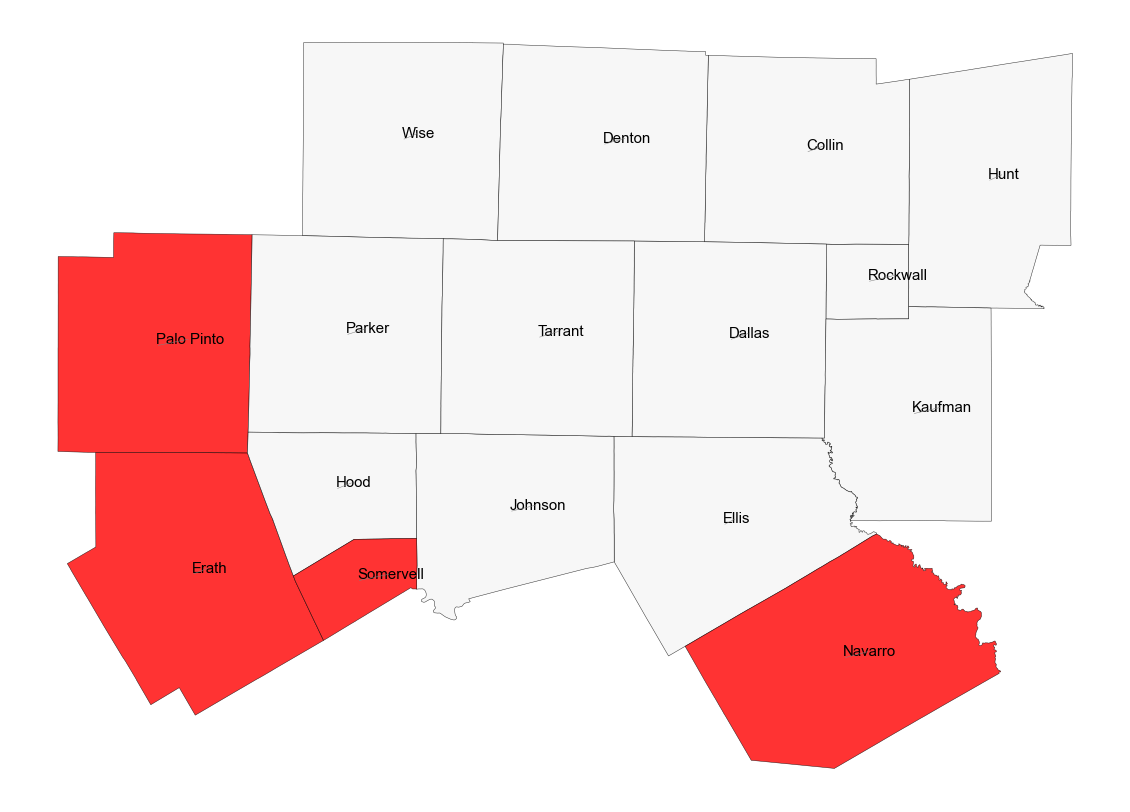

In [55]:
plt.rcParams.update({'font.family': 'arial'})
ax = counties.plot(figsize = (20, 20), color = counties['color'], edgecolor = "black", linewidth = 0.5, alpha = .8)
ax.axis('off')
texts = []

for x, y, label in zip(za_points.geometry.x, za_points.geometry.y, za_points["COUNTY"]):
    texts.append(plt.text(x, y, label, fontsize = 15))

aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

## 7.2 NCTCOG + Street Network

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

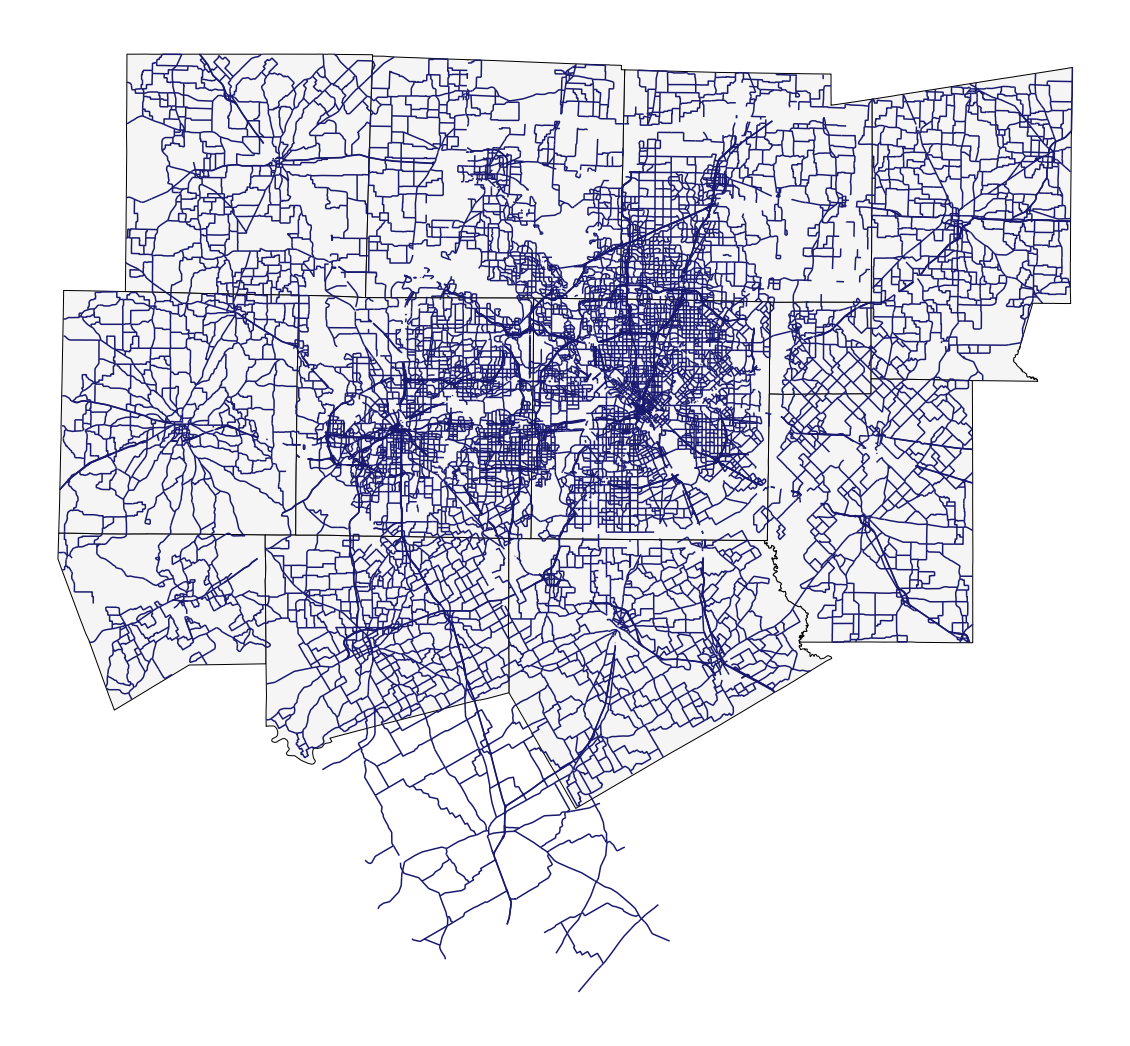

In [56]:
counties_trim.to_crs(3857, inplace=True)
Mobility2045.to_crs(3857, inplace=True)
Mobility2045.geometry = Mobility2045['geometry']
#counties base
base = counties_trim.plot(figsize=(20,20),color='whitesmoke', edgecolor='black')
base.axis('off')
# add street network
Mobility2045.plot(ax=base, color='midnightblue')

## 7.3 Excess Pavement

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

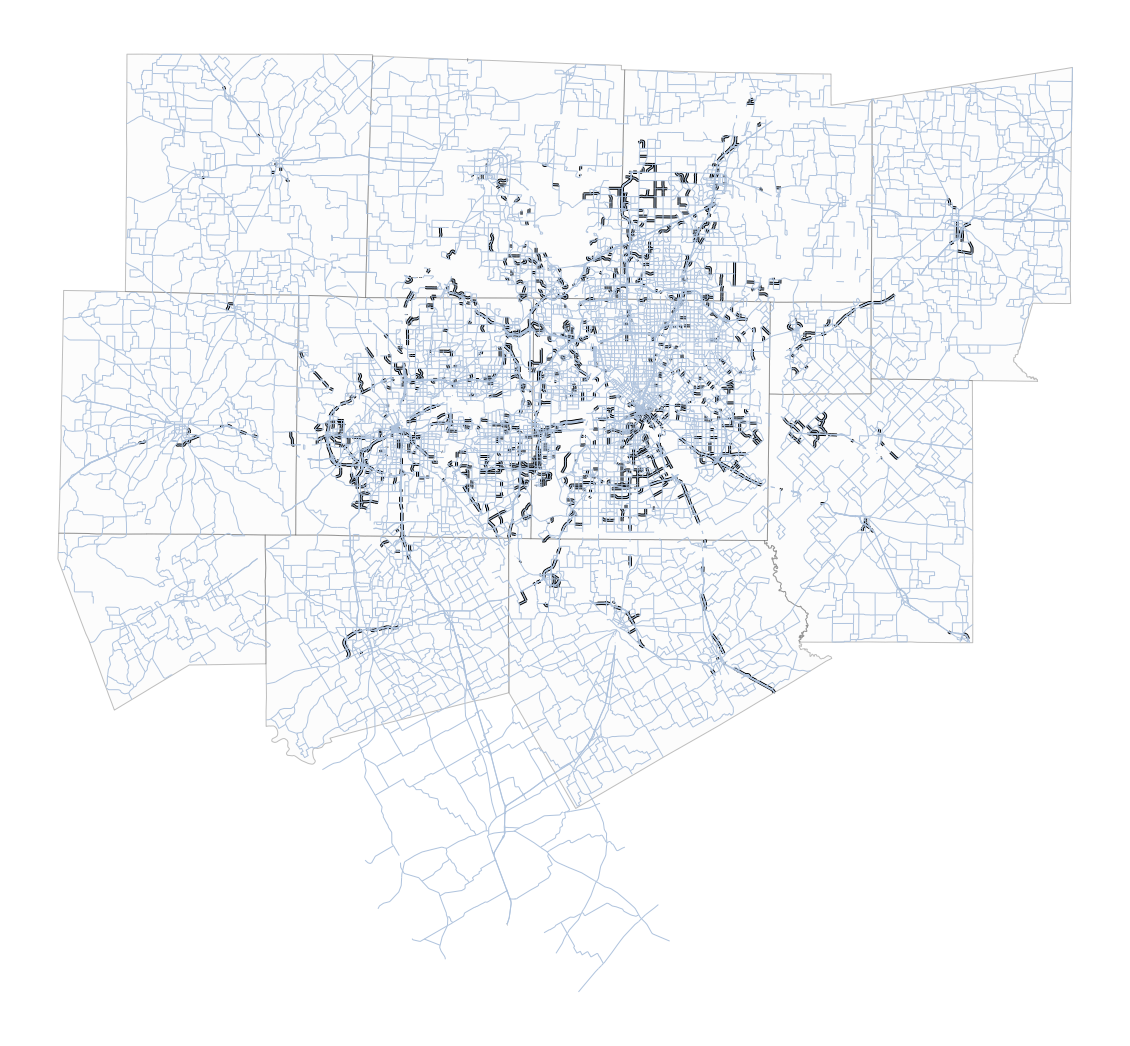

In [57]:
counties_trim.to_crs(3857, inplace=True)
all_excess.to_crs(3857, inplace=True)
Mobility2045.to_crs(3857, inplace=True)
Mobility2045.geometry = Mobility2045['geometry']
#counties base
base = counties_trim.plot(figsize=(20,20),color='whitesmoke', edgecolor='black', alpha=.25)
base.axis('off')
# add street network
all_excess.plot(ax=base, color='black', linewidth=3)
Mobility2045.plot(ax=base, color='lightsteelblue', linewidth=1)

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

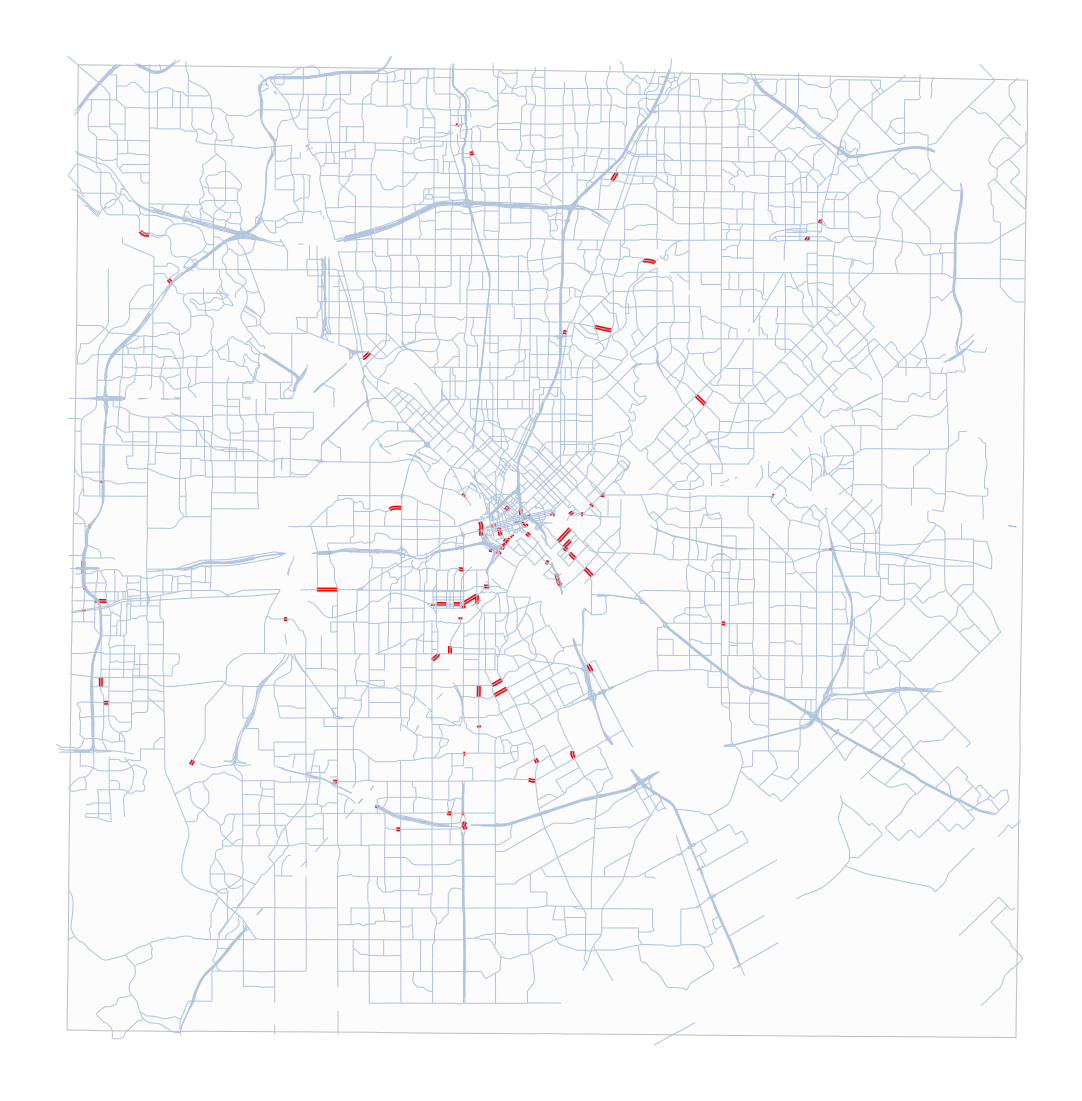

In [58]:
counties_trim.to_crs(3857, inplace=True)
all_excess.to_crs(3857, inplace=True)
#counties base
base = counties_trim.loc[counties['COUNTY'] == 'Dallas'].plot(figsize=(20,20),color='whitesmoke', edgecolor='black', alpha=.25)
base.axis('off')
# add street network
x_danger.loc[x_danger['COUNTY'] == 'Dallas'].plot(ax=base, color='red', linewidth=4)
Mobility2045_CRIS.loc[Mobility2045_CRIS['COUNTY'] == 'Dallas'].plot(ax=base, color='lightsteelblue', linewidth=1)

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

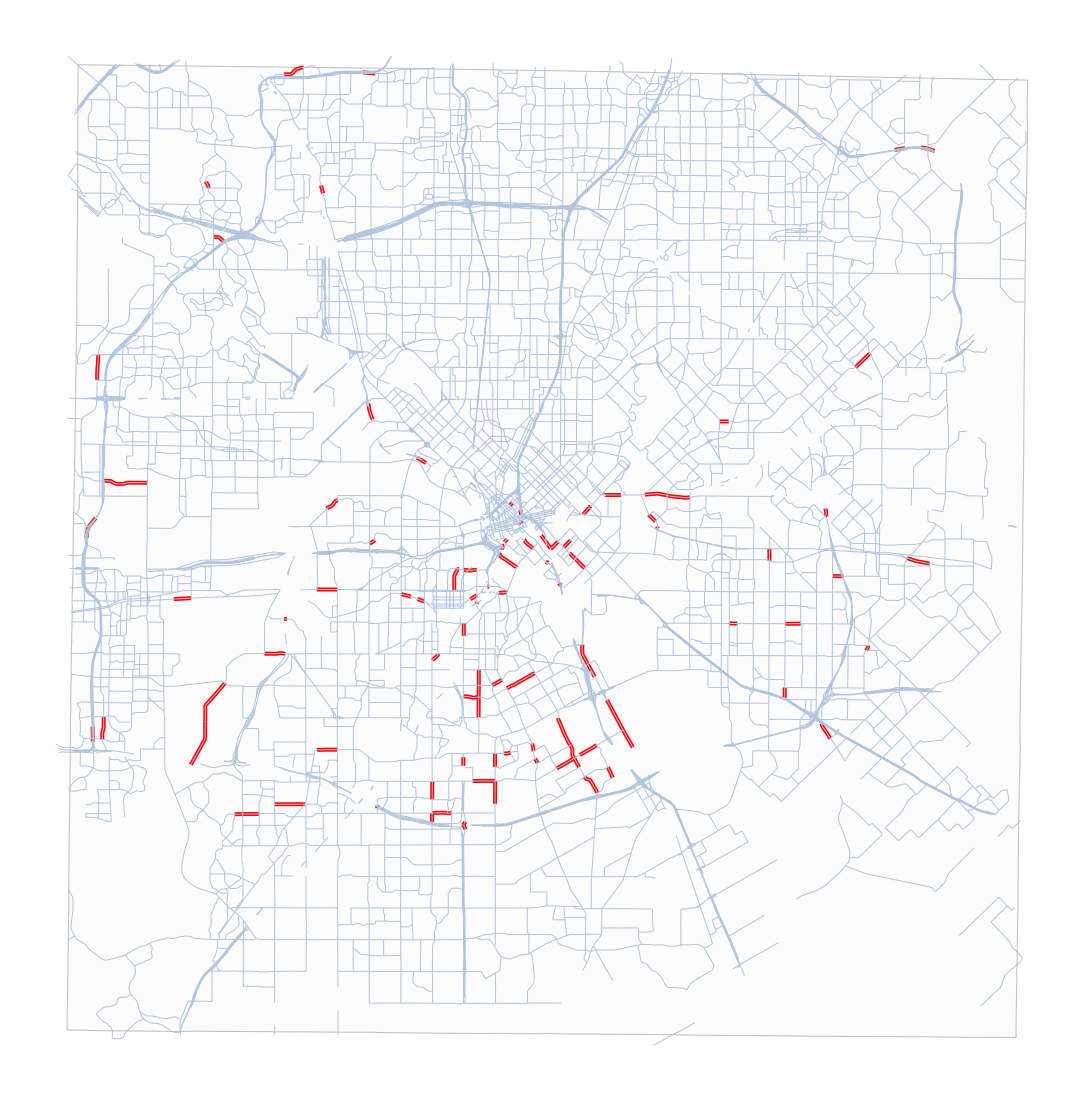

In [59]:
counties_trim.to_crs(3857, inplace=True)
all_excess.to_crs(3857, inplace=True)
#counties base
base = counties_trim.loc[counties['COUNTY'] == 'Dallas'].plot(figsize=(20,20),color='whitesmoke', edgecolor='black', alpha=.25)
base.axis('off')
# add street network
x_fatal.loc[x_fatal['COUNTY'] == 'Dallas'].plot(ax=base, color='red', linewidth=4)
Mobility2045_CRIS.loc[Mobility2045_CRIS['COUNTY'] == 'Dallas'].plot(ax=base, color='lightsteelblue', linewidth=1)

## 7.4 Equity Index

(-10929240.739372438,
 -10658635.302397976,
 3761004.263224073,
 3962206.049416179)

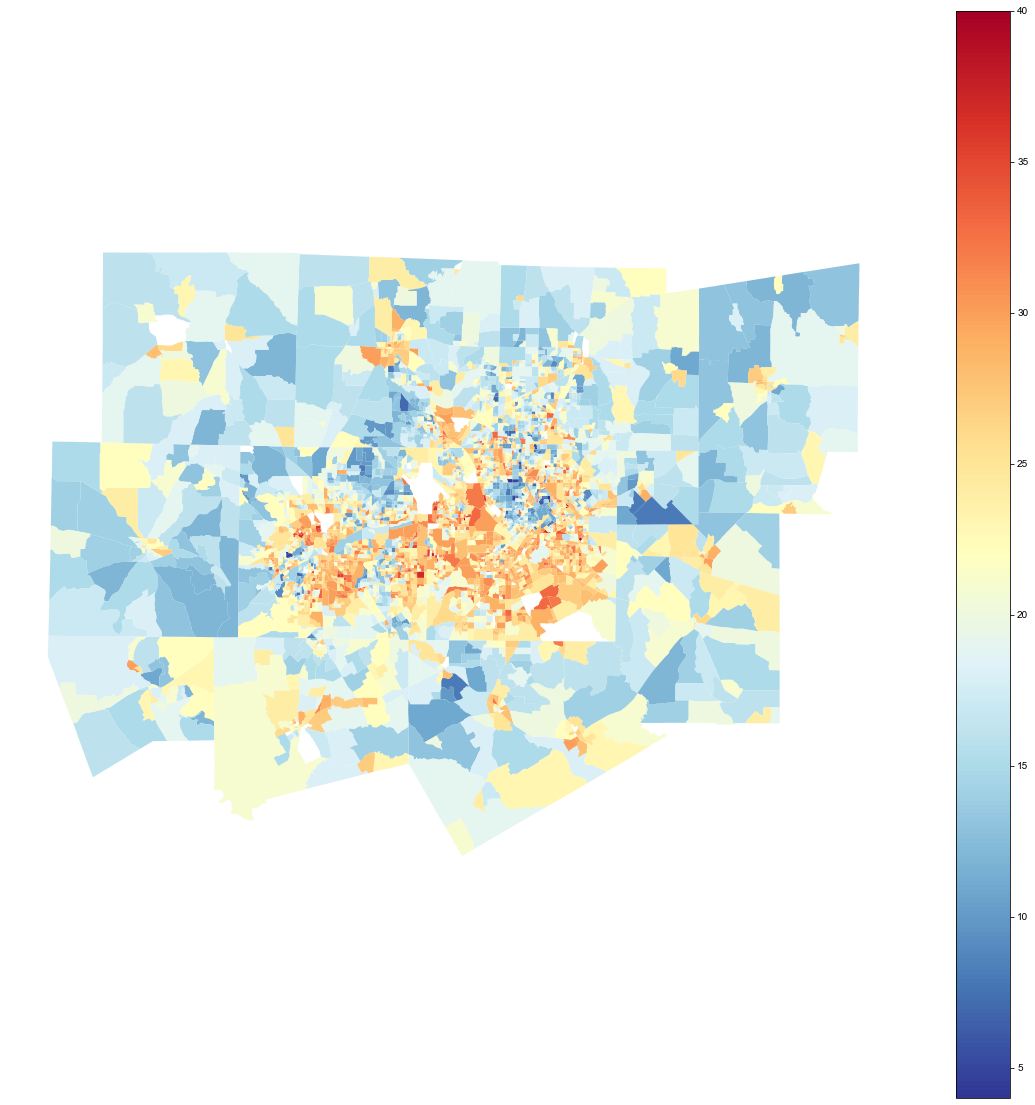

In [60]:
fig, ax = plt.subplots(figsize=(20,20))
demog_cities.plot(ax=ax, column='EFC_score',cmap='RdYlBu_r', legend=True)
ax.axis('off')

## 7.5 Crashes by Street per Meter

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 9
  Warn("Warning: setting k to %d" % k_q, UserWarning)


Text(0.5, 1.0, 'Crashes by Mile')

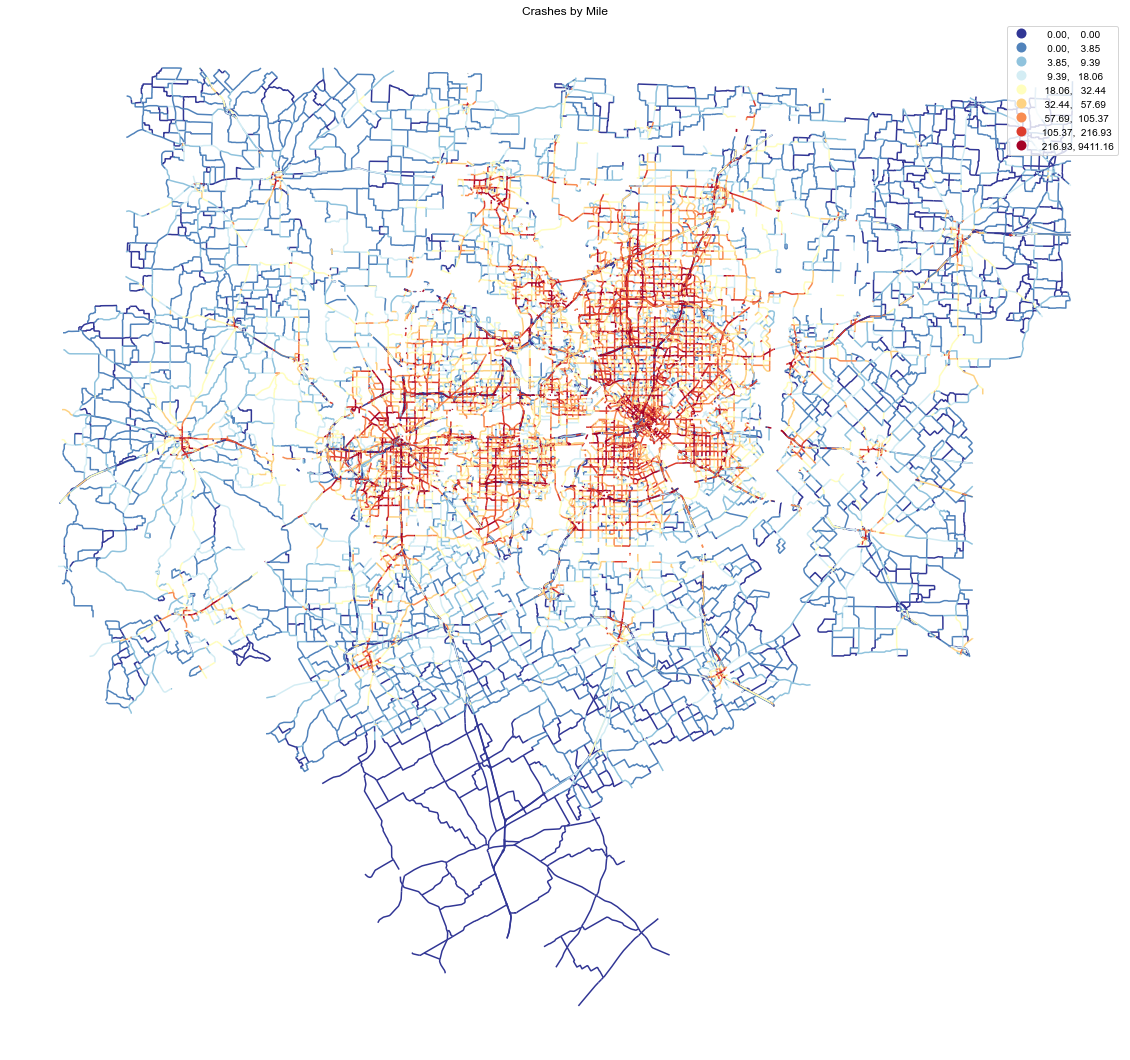

In [61]:
fig, ax = plt.subplots(figsize=(20,20))

# add isochrones
Mobility2045_CRIS.plot(ax=ax,
               column='crash_per_mile',
               scheme='quantiles',
               k=10,
               cmap='RdYlBu_r',
               legend=True)

# no axis
ax.axis('off')

# title
ax.set_title('Crashes by Mile')

## 7.6 Histogram of Street VOC

In [62]:
hist_data = pd.DataFrame(Mobility2045_CRIS)
hist_data.drop(['geometry', 'buffer'], axis=1, inplace=True)
excess_AM_AB_18['AMHRVOC_AB_18'].max()
hist_data.to_csv('histdata.csv')

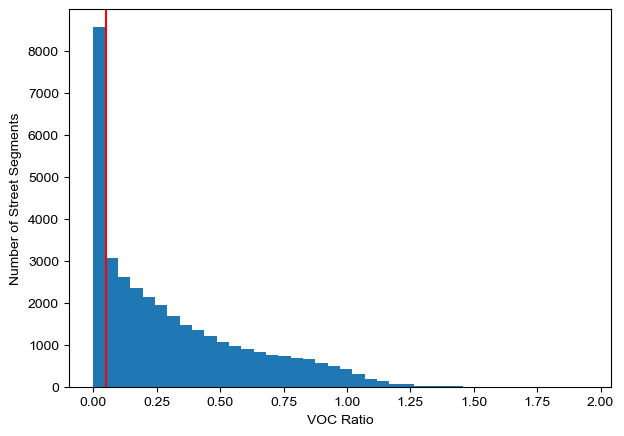

In [63]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100, 'font.family': 'arial'})

# Plot Histogram on x
x = Mobility2045_CRIS['AMHRVOC_AB_18']
plt.hist(x, bins=40, color='#1F77B4')
plt.axvline(x=0.048219, color='red')
plt.gca().set(ylabel='Number of Street Segments', xlabel='VOC Ratio');

## 7.7 Histogram of Excess Pavement by # of lanes, LOS, traffic vols

(array([25352.,     0.,     0.,     0.,     0.,  5406.,     0.,     0.,
            0.,  4475.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

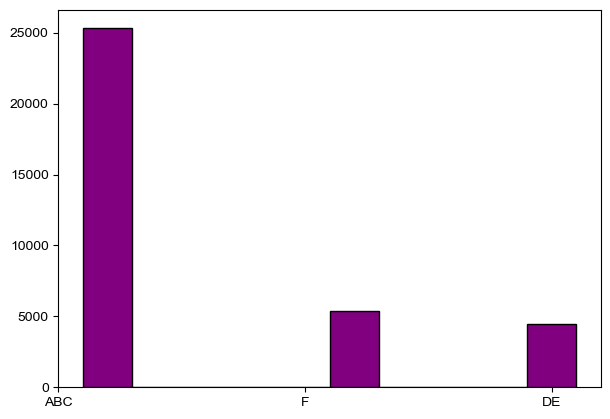

In [64]:
plt.hist(Mobility2045_CRIS['DAYHRLOS_18'], align='right', color='purple', edgecolor='black')

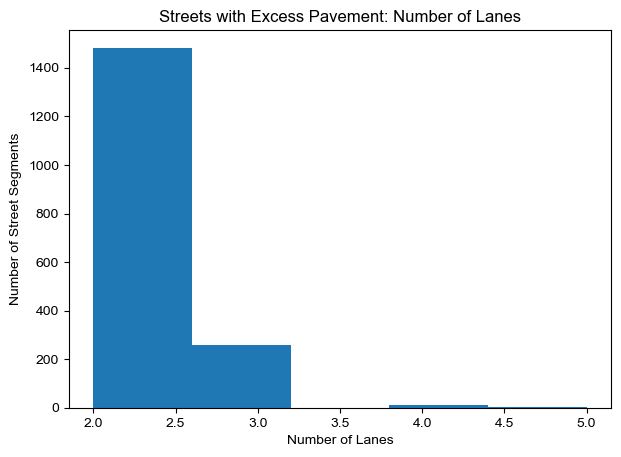

In [65]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
# Plot Histogram on x
x = excess_AM_AB_18['PKLNA_18']
ax = plt.hist(x, bins=5)
plt.gca().set(title='Streets with Excess Pavement: Number of Lanes', ylabel='Number of Street Segments', xlabel='Number of Lanes');

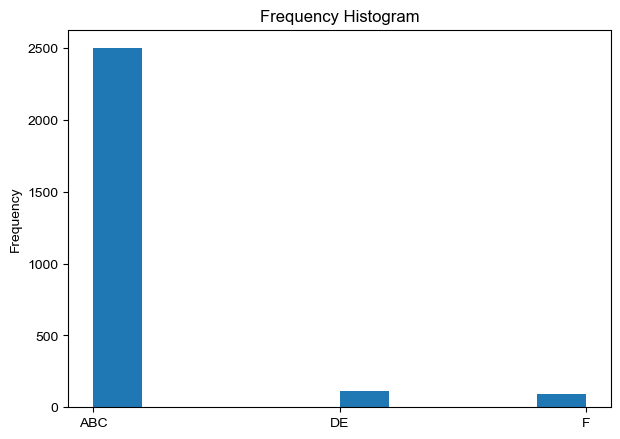

In [66]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = all_excess['DAYHRLOS_18']
plt.hist(x, bins=10)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [67]:
Mobility2045_CRIS.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

COUNTY    lane_miles
0     Dallas  13060.788194
1    Tarrant   9434.307074
2     Collin   5335.655124
3     Denton   3379.699108
4      Ellis   1828.251076
5    Johnson   1498.854642
6    Kaufman   1050.499776
7     Parker    853.188739
8       Hunt    839.227327
9   Rockwall    592.974575
10      Wise    571.236400
11      Hood    295.176486

In [68]:
Mobility2045_CRIS.groupby(['FUNCL_18'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

FUNCL_18    lane_miles
0         4  20047.916742
1         3  15178.602949
2         2   8222.803611
3         1   4394.719156
4         7   2507.386025
5         6   1024.356589
6         8    163.524021

In [69]:
danger.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

COUNTY   lane_miles
0     Dallas  1880.605417
1    Tarrant  1055.675587
2     Collin   488.808544
3     Denton   309.294246
4    Johnson    24.776322
5     Parker    24.326254
6      Ellis    23.323239
7   Rockwall    20.141500
8    Kaufman    18.589089
9       Hunt    14.392347
10      Hood    13.811710
11      Wise     5.462552

In [70]:
all_excess.groupby(['FUNCL_18'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

FUNCL_18   lane_miles
0         4  1928.357737
1         3  1191.117342
2         7   719.136343
3         2   177.463122
4         1   129.723881
5         6    45.988882
6         8    35.944330

In [71]:
all_excess.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

COUNTY   lane_miles
0     Dallas  1548.986046
1    Tarrant  1181.710041
2     Collin   605.394165
3     Denton   367.345153
4      Ellis   150.721540
5    Kaufman    89.321957
6   Rockwall    66.565785
7       Hunt    61.368589
8    Johnson    54.472668
9     Parker    45.945729
10      Wise     8.586378

In [72]:
x_danger.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

COUNTY  lane_miles
0   Dallas   90.031059
1  Tarrant   24.587884
2   Denton    9.439828
3   Collin    8.645870
4     Hunt    7.297791
5  Kaufman    4.452779
6    Ellis    2.918900
7  Johnson    1.030545
8     Wise    0.511221
9   Parker    0.409768

In [73]:
fatal.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

COUNTY   lane_miles
0     Dallas  2736.870771
1    Tarrant  1638.092803
2     Collin   801.487547
3     Denton   445.614849
4      Ellis   195.615746
5    Kaufman   161.017356
6    Johnson   156.017069
7       Hunt   139.033821
8     Parker   115.541000
9       Hood    58.659643
10  Rockwall    55.030198
11      Wise    47.631151

In [74]:
x_fatal.groupby(['COUNTY'])[['lane_miles']].sum().sort_values('lane_miles', ascending=False).reset_index()

COUNTY  lane_miles
0   Dallas  243.700910
1  Tarrant  102.509261
2   Collin   34.945927
3   Denton   24.301939
4     Hunt   21.712449
5  Kaufman   11.865666
6   Parker    7.432847
7    Ellis    1.749036
8  Johnson    0.687022